# Constrained uniform distribution

See the issue I made here https://github.com/pymc-devs/pymc/issues/5215

In [1]:
import pymc as pm
import arviz as az
import numpy as np
import aesara.tensor as at
import matplotlib.pyplot as plt

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 6])

K = len(np.unique(y))
print(f"K = {K} categories")
print(f"K-1 = {K-1} thresholds")

K = 7 categories
K-1 = 6 thresholds


In [4]:
def constrainedUniform(N, min=0, max=1):
    return pm.Deterministic('theta',
                             at.concatenate([
                                 np.ones(1)*min,
                                 at.extra_ops.cumsum(pm.Dirichlet("theta_unknown", a=np.ones(N - 2))) * (min+(max-min))
                             ])
                           )

In [5]:
with pm.Model() as model:
    theta = constrainedUniform(K, min=0, max=1)
    mu = pm.Normal('mu', mu=K/2, sigma=K)
    sigma = pm.HalfNormal("sigma", 1)
    pm.OrderedProbit("y_obs", cutpoints=theta, eta=mu, sigma=sigma, observed=y)

In [6]:
# initial = np.linspace(0.1, 0.9, K-2)
# print(initial)

In [7]:
with model:
    trace = pm.sample()#initvals={"theta_unknown": initial})
    ppc = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/git/pymc/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_unknown, mu, sigma]
/Users/benjamv/git/pymc/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


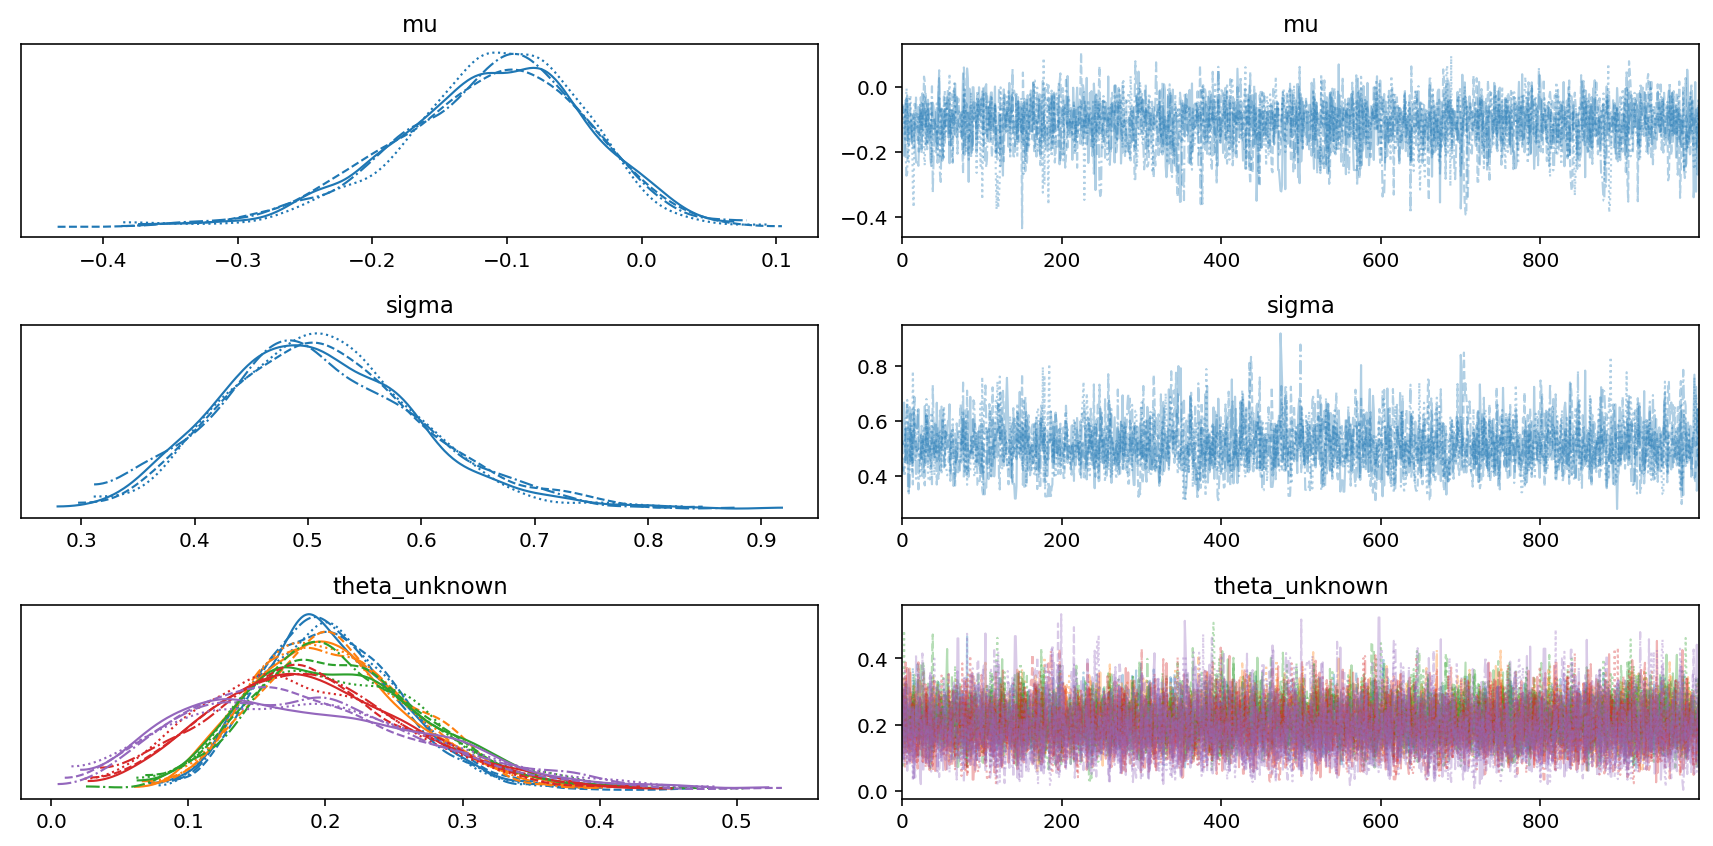

In [8]:
az.plot_trace(trace, var_names=["mu", "sigma", "theta_unknown"]);
plt.tight_layout()

Note `theta_unknown` is prior to the `cum_sum` operation, so it doesn't really reflect the actual cutpoint positions that well.

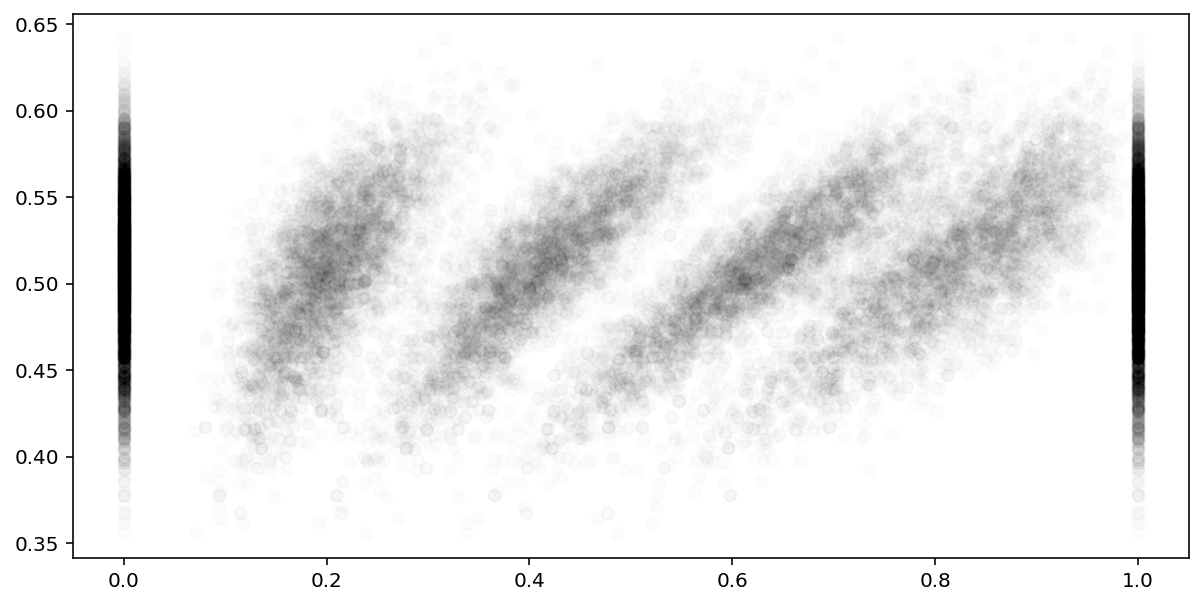

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

cutpoints = trace.posterior['theta'].stack(sample=["chain", "draw"])
sample_means = cutpoints.mean(dim="theta_dim_0").data
for i in np.argsort(sample_means):
    ax.plot(cutpoints.data[:,i], sample_means[i]*np.ones((K-1,1)), 'ko', alpha=0.01)